In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
%cd "/content/drive/My Drive/automatic-asset-classification"
%ls "/content/drive/My Drive/automatic-asset-classification"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification
data/  models/


# Autoencoder 1

## Data

In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
size = 224
batchsize = 32
tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).split_by_rand_pct(seed=2).label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

## Model

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[0:3]))
        for param in resnet.parameters():
            param.requires_grad = False

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True)
        )

    def encode(self, x): return self.encoder(x)

    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(decoded, min = 0, max = 1)

In [5]:
autoencoder = AutoEncoder();

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


## Training

In [0]:
learn = Learner(data, autoencoder, loss_func=F.mse_loss);

In [9]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.212566,#na#,02:42
1,0.212176,#na#,00:17
2,0.208735,#na#,00:17
3,0.178113,#na#,00:17
4,0.144742,#na#,00:17
5,0.123472,#na#,00:16
6,0.114010,#na#,00:17
7,0.109495,#na#,00:17


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-04
Min loss divided by 10: 3.31E-01


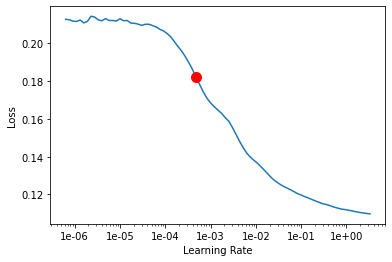

In [10]:
learn.recorder.plot(suggestion = True)

In [11]:
learn.fit_one_cycle(100, max_lr = 1.5e-02)

epoch,train_loss,valid_loss,time
0,0.089737,0.057726,01:15
1,0.055020,0.022657,00:21
2,0.040010,0.016178,00:21
3,0.031940,0.014126,00:21
4,0.026103,0.009115,00:21
5,0.021181,0.009762,00:21
6,0.017806,0.006508,00:21
7,0.014989,0.007017,00:21
8,0.012684,0.006264,00:21
9,0.010878,0.005069,00:22


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
learn.save('ae_res_1')

## Results

In [0]:
learn = learn.load('ae_res_1')

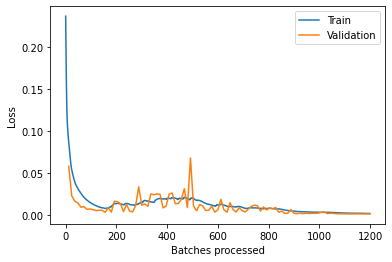

In [15]:
learn.recorder.plot_losses()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


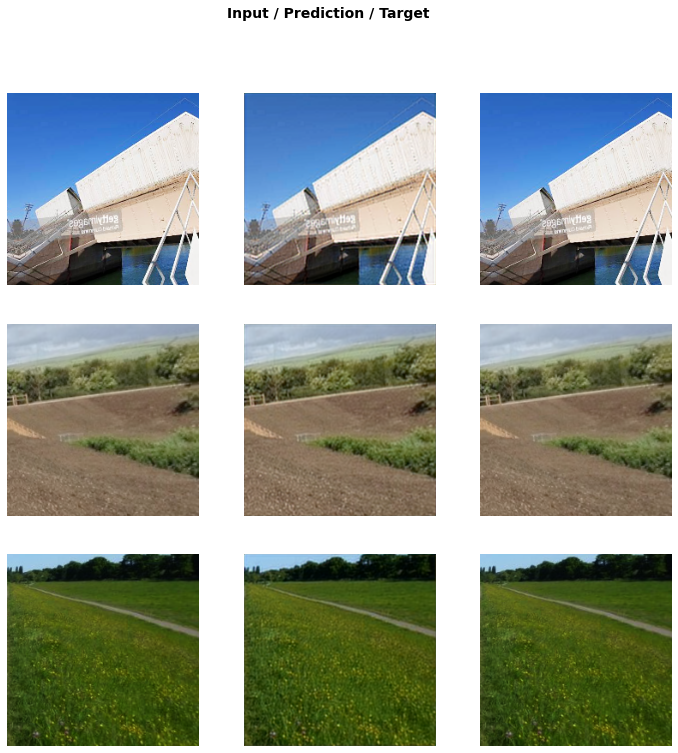

In [16]:
learn.show_results(ds_type=DatasetType.Train, rows =3)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


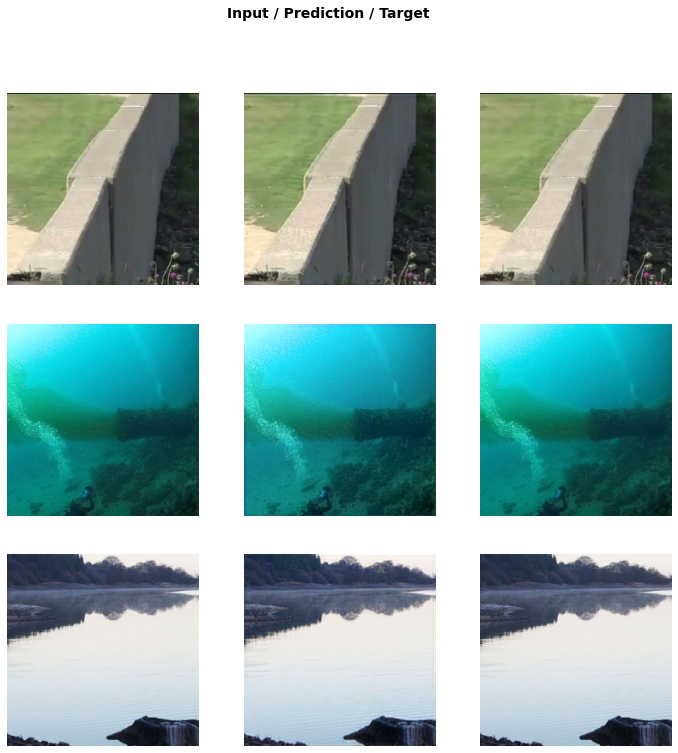

In [17]:
learn.show_results(ds_type=DatasetType.Valid, rows =3)

# AutoEncoder 2

## Data

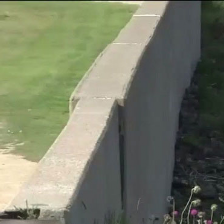

In [26]:
example = data.valid_ds[0]
example[0]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


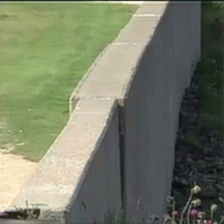

In [27]:
test = example[0].data
test = (test - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

autoencoder.eval()
with torch.no_grad():
  pred = learn.model(test.unsqueeze_(0).cuda())

Image(pred.squeeze(0).cpu())

As can be seen the image loses quality slightly, which can be also seen on the plots above, however currently the plots still appear to focus on the asset which is what we would like.

In [0]:
train_batches = [item[0] for item in iter(data.train_dl)]
valid_batches = [item[0] for item in iter(data.valid_dl)]

In [0]:
autoencoder.eval()
autoencoder.cuda()
encoded_train_batches = [];
encoded_valid_batches = [];

with torch.no_grad():

  for train in train_batches:
    encoded_train = autoencoder.encode(train);
    encoded_train_batches.append(encoded_train);
  
  for valid in valid_batches:
    encoded_valid = autoencoder.encode(valid);
    encoded_valid_batches.append(encoded_valid);

In [131]:
encoded_train_batches = np.concatenate([batch.cpu().numpy() for batch in encoded_train_batches])
encoded_valid_batches = np.concatenate([batch.cpu().numpy() for batch in encoded_valid_batches])
print(encoded_train_batches.shape, encoded_valid_batches.shape)

(384, 64, 112, 112) (96, 64, 112, 112)


In [0]:
class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = 2 # binary label
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
train_ds, valid_ds = ArrayDataset(encoded_train_batches, encoded_train_batches), ArrayDataset(encoded_valid_batches, encoded_valid_batches)

In [0]:
data2 = DataBunch.create(train_ds, valid_ds, bs=32)

## Model

In [0]:
class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[3:5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[1][i].bn1.parameters():
                param.requires_grad = True
            for param in resnet[1][i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

## Training

In [32]:
autoencoder2 = AutoEncoder2()
learn2 = Learner(data2, autoencoder2, loss_func = F.mse_loss)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [33]:
learn2.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.101617,0.080443,00:03


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [34]:
learn2.lr_find()

epoch,train_loss,valid_loss,time
0,0.077124,#na#,00:02
1,0.076998,#na#,00:02
2,0.076044,#na#,00:02
3,0.074986,#na#,00:02
4,0.075275,#na#,00:02
5,0.078964,#na#,00:02
6,0.087406,#na#,00:02
7,0.099684,#na#,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.29E-05


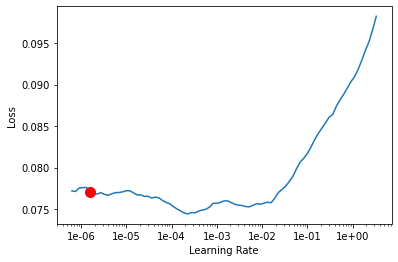

In [35]:
learn2.recorder.plot(suggestion = True)

In [36]:
learn2.fit_one_cycle(100, max_lr = 1.5e-04)

epoch,train_loss,valid_loss,time
0,0.076692,0.079830,00:02
1,0.076139,0.078580,00:02
2,0.075327,0.077076,00:02
3,0.074439,0.075469,00:02
4,0.073492,0.073956,00:02
5,0.072480,0.072500,00:02
6,0.071387,0.071057,00:02
7,0.070286,0.069796,00:02
8,0.069278,0.069203,00:02
9,0.068383,0.068518,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
learn2.save('ae_res_2')

## Results

In [0]:
learn2 = learn2.load('ae_res_2')

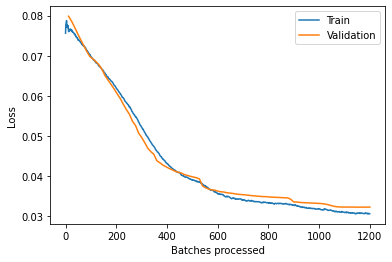

In [39]:
learn2.recorder.plot_losses()

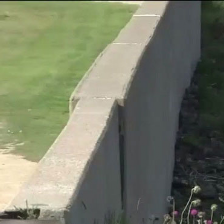

In [40]:
img = data.valid_ds[0][0]
img

In [0]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


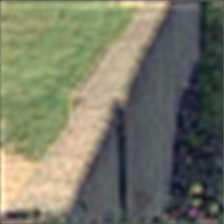

In [45]:
learn.model.eval()
learn2.model.eval()
with torch.no_grad():
  pred = learn.model.encode(example.unsqueeze_(0).cuda())
  pred = learn2.model(pred)
  pred = learn.model.decode(pred)

Image(pred.squeeze(0).cpu())

Quality at this point is decreasing fast.

# Autoencoder 3

## Data

In [81]:
encoded_train_batches.shape

(384, 64, 112, 112)

In [132]:
learn2.model.eval()
encoded_train_batches = torch.tensor(encoded_train_batches).cuda()
encoded_valid_batches = torch.tensor(encoded_train_batches).cuda()

with torch.no_grad():

    encoded_train_batches = learn2.model.encode(encoded_train_batches);  
    encoded_valid_batches = learn2.model.encode(encoded_valid_batches);


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [133]:
encoded_train_batches = encoded_train_batches.cpu().numpy()
encoded_valid_batches = encoded_valid_batches.cpu().numpy()
print(encoded_train_batches.shape, encoded_valid_batches.shape)

(384, 64, 56, 56) (384, 64, 56, 56)


In [0]:
train_ds, valid_ds = ArrayDataset(encoded_train_batches, encoded_train_batches), ArrayDataset(encoded_valid_batches, encoded_valid_batches)

In [0]:
data3 = DataBunch.create(train_ds, valid_ds, bs=32)

## Model

In [0]:
class AutoEncoder3(nn.Module):
    def __init__(self):
        super(AutoEncoder3, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

## Training

In [88]:
autoencoder3 = AutoEncoder3()
learn3 = Learner(data3, autoencoder3, loss_func = F.mse_loss)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [89]:
learn3.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.400302,0.513781,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [90]:
learn3.lr_find()

epoch,train_loss,valid_loss,time
0,0.311966,#na#,00:01
1,0.311834,#na#,00:01
2,0.311509,#na#,00:01
3,0.309040,#na#,00:01
4,0.301415,#na#,00:01
5,0.283164,#na#,00:01
6,0.261001,#na#,00:01
7,0.269523,#na#,00:01


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-02
Min loss divided by 10: 3.02E-02


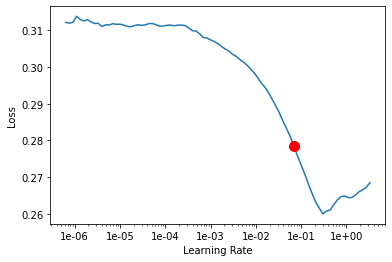

In [91]:
learn3.recorder.plot(suggestion = True)

In [92]:
learn3.fit_one_cycle(100, max_lr = 6.92e-02)

epoch,train_loss,valid_loss,time
0,0.290873,0.424886,00:02
1,0.275765,0.314658,00:02
2,0.261300,0.243730,00:02
3,0.246565,0.203737,00:02
4,0.230814,0.183549,00:02
5,0.214070,0.156895,00:02
6,0.196802,0.142659,00:02
7,0.179250,0.119962,00:02
8,0.162147,0.103391,00:02
9,0.145760,0.096885,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


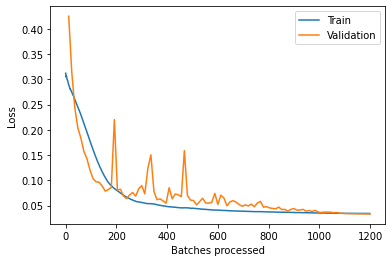

In [93]:
learn3.recorder.plot_losses()

## Results

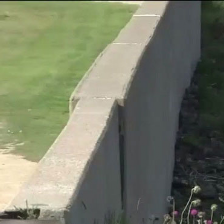

In [94]:
img = data.valid_ds[0][0]
img

In [0]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


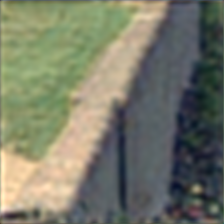

In [96]:
learn.model.eval()
learn2.model.eval()
learn3.model.eval()
with torch.no_grad():
  pred = learn.model.encode(example.unsqueeze_(0).cuda())
  pred = learn2.model.encode(pred)
  pred = learn3.model(pred)
  pred = learn2.model.decode(pred)
  pred = learn.model.decode(pred)

Image(pred.squeeze(0).cpu())

Quality between 2 models and 3 has barely reduced the quality suggesting a good fit for us. Another example:

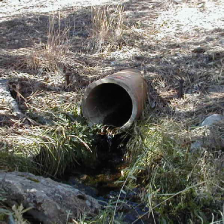

In [100]:
img = data.valid_ds[20][0]
img

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


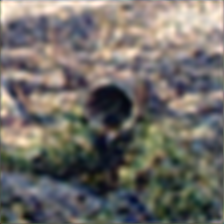

In [101]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

learn.model.eval()
learn2.model.eval()
learn3.model.eval()
with torch.no_grad():
  pred = learn.model.encode(example.unsqueeze_(0).cuda())
  pred = learn2.model.encode(pred)
  pred = learn3.model(pred)
  pred = learn2.model.decode(pred)
  pred = learn.model.decode(pred)

Image(pred.squeeze(0).cpu())

The issue with the above plot is we would like to recognise the asset, hopefully when we do the final training this will still work ok.

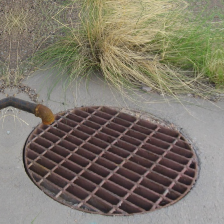

In [107]:
img = data.train_ds[200][0]
img

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


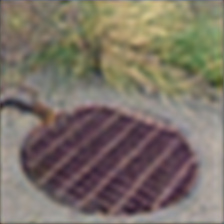

In [108]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

learn.model.eval()
learn2.model.eval()
learn3.model.eval()
with torch.no_grad():
  pred = learn.model.encode(example.unsqueeze_(0).cuda())
  pred = learn2.model.encode(pred)
  pred = learn3.model(pred)
  pred = learn2.model.decode(pred)
  pred = learn.model.decode(pred)

Image(pred.squeeze(0).cpu())

In [0]:
learn3.save('ae_res_3')

# Autoencoder 4

## Data

In [134]:
learn3.model.eval()
encoded_train_batches = torch.tensor(encoded_train_batches).cuda()
encoded_valid_batches = torch.tensor(encoded_train_batches).cuda()

with torch.no_grad():

    encoded_train_batches = learn3.model.encode(encoded_train_batches);  
    encoded_valid_batches = learn3.model.encode(encoded_valid_batches);

encoded_train_batches = encoded_train_batches.cpu().numpy()
encoded_valid_batches = encoded_valid_batches.cpu().numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
train_ds, valid_ds = ArrayDataset(encoded_train_batches, encoded_train_batches), ArrayDataset(encoded_valid_batches, encoded_valid_batches)

In [0]:
data4 = DataBunch.create(train_ds, valid_ds, bs=32)

## Model

In [0]:
class AutoEncoder4(nn.Module):
    def __init__(self):
        super(AutoEncoder4, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[6]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

In [138]:
autoencoder4 = AutoEncoder4()
learn4 = Learner(data4, autoencoder4, loss_func = F.mse_loss)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


## Training

In [139]:
learn4.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,2.497567,2.782780,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [140]:
learn4.lr_find()

epoch,train_loss,valid_loss,time
0,2.352389,#na#,00:01
1,2.352368,#na#,00:01
2,2.350848,#na#,00:01
3,2.344597,#na#,00:01
4,2.324641,#na#,00:01
5,2.249015,#na#,00:01
6,1.941195,#na#,00:01
7,1.927562,#na#,00:01


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-01
Min loss divided by 10: 6.31E-02


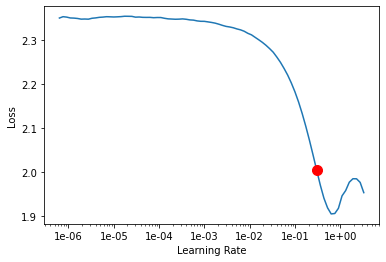

In [141]:
learn4.recorder.plot(suggestion = True)

In [142]:
learn4.fit_one_cycle(100, max_lr = 3.02e-01)

epoch,train_loss,valid_loss,time
0,2.137132,2.316233,00:02
1,1.929857,1.743395,00:02
2,1.726468,1.247442,00:02
3,1.517363,0.884193,00:02
4,1.304693,0.615630,00:02
5,1.104060,0.518361,00:02
6,0.938774,0.485626,00:02
7,0.820970,0.654183,00:02
8,0.729483,0.527346,00:02
9,0.653935,0.465165,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
learn4.save('ae_res_4')

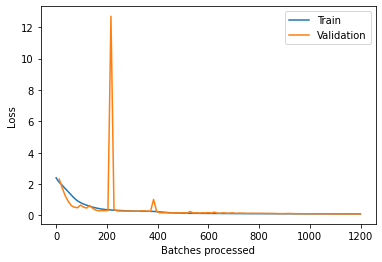

In [145]:
learn4.recorder.plot_losses()

In [146]:
learn4.lr_find()

epoch,train_loss,valid_loss,time
0,0.092595,#na#,00:01
1,0.092801,#na#,00:01
2,0.092797,#na#,00:01
3,0.092811,#na#,00:01
4,0.092794,#na#,00:01
5,0.093021,#na#,00:01
6,0.097803,#na#,00:01
7,0.117956,#na#,00:01


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


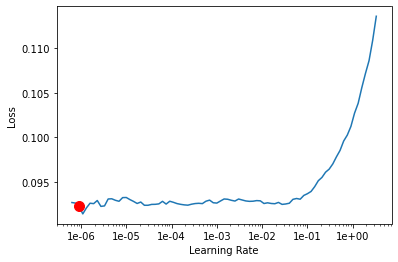

In [147]:
learn4.recorder.plot(suggestion = True)

In [148]:
learn4.fit_one_cycle(20, max_lr = 1.10e-07)

epoch,train_loss,valid_loss,time
0,0.092936,0.091723,00:02
1,0.092886,0.091720,00:02
2,0.092835,0.091718,00:02
3,0.092855,0.091719,00:02
4,0.092824,0.091720,00:02
5,0.092830,0.091720,00:02
6,0.092791,0.091725,00:02
7,0.092787,0.091717,00:02
8,0.092745,0.091715,00:02
9,0.092710,0.091718,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
learn4.save('ae_res_4')

## Results

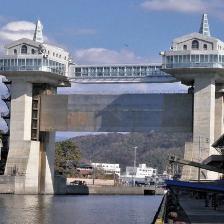

In [154]:
img = data.train_ds[120][0]
img

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


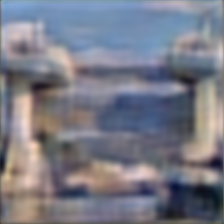

In [156]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

learn.model.eval()
learn2.model.eval()
learn3.model.eval()
with torch.no_grad():
  pred = learn.model.encode(example.unsqueeze_(0).cuda())
  pred = learn2.model.encode(pred)
  pred = learn3.model.encode(pred)
  pred = learn4.model(pred)
  pred = learn3.model.decode(pred)
  pred = learn2.model.decode(pred)
  pred = learn.model.decode(pred)

Image(pred.squeeze(0).cpu())

Almost all data has been lost when translating back to full image, however the flood gate is almost visible suggesting these compressed layers may have good representations of assets.

# Autoencoder 5

## data

In [157]:
learn4.model.eval()
encoded_train_batches = torch.tensor(encoded_train_batches).cuda()
encoded_valid_batches = torch.tensor(encoded_train_batches).cuda()

with torch.no_grad():

    encoded_train_batches = learn4.model.encode(encoded_train_batches);  
    encoded_valid_batches = learn4.model.encode(encoded_valid_batches);

encoded_train_batches = encoded_train_batches.cpu().numpy()
encoded_valid_batches = encoded_valid_batches.cpu().numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
train_ds, valid_ds = ArrayDataset(encoded_train_batches, encoded_train_batches), ArrayDataset(encoded_valid_batches, encoded_valid_batches)

In [0]:
data5 = DataBunch.create(train_ds, valid_ds, bs=32)

## Model

In [0]:
class AutoEncoder5(nn.Module):
    def __init__(self):
        super(AutoEncoder5, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[7]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

In [166]:
autoencoder5 = AutoEncoder5()
learn5 = Learner(data5, autoencoder5, loss_func = F.mse_loss)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


## Training

In [167]:
learn5.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,7.592419,7.719055,00:01


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [168]:
learn5.lr_find()

epoch,train_loss,valid_loss,time
0,7.400306,#na#,00:00
1,7.400096,#na#,00:00
2,7.397024,#na#,00:00
3,7.388051,#na#,00:00
4,7.361883,#na#,00:00
5,7.237803,#na#,00:00
6,6.554108,#na#,00:00
7,6.724586,#na#,00:00


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.25E-01
Min loss divided by 10: 1.32E-01


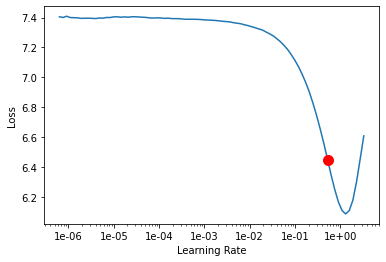

In [169]:
learn5.recorder.plot(suggestion = True)

In [170]:
learn5.fit_one_cycle(100, max_lr = 5.25e-1)

epoch,train_loss,valid_loss,time
0,6.860607,6.020699,00:01
1,6.280663,5.130355,00:01
2,5.710346,4.172380,00:01
3,5.097743,2.804603,00:01
4,4.432339,1.899067,00:01
5,3.770437,1.619931,00:01
6,3.190241,1.527937,00:01
7,2.735443,1.464805,00:01
8,2.392901,1.361646,00:01
9,2.107013,1.542003,00:01


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


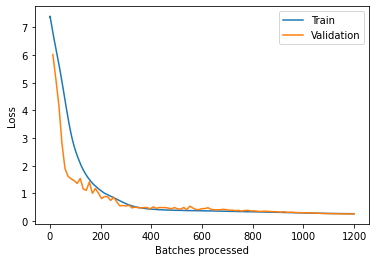

In [171]:
learn5.recorder.plot_losses()

In [172]:
learn5.lr_find()

epoch,train_loss,valid_loss,time
0,0.266724,#na#,00:00
1,0.265891,#na#,00:00
2,0.265987,#na#,00:00
3,0.265833,#na#,00:00
4,0.265892,#na#,00:00
5,0.266137,#na#,00:00
6,0.280301,#na#,00:00
7,0.330648,#na#,00:00


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-05
Min loss divided by 10: 2.09E-06


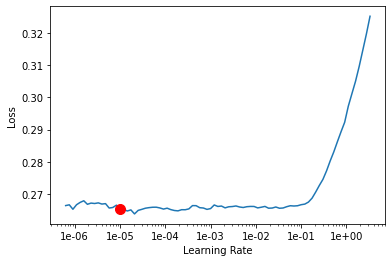

In [173]:
learn5.recorder.plot(suggestion = True)

In [174]:
learn5.fit_one_cycle(100, max_lr = 1e-05)

epoch,train_loss,valid_loss,time
0,0.264889,0.260553,00:01
1,0.264990,0.260548,00:01
2,0.265576,0.260546,00:01
3,0.265193,0.260545,00:01
4,0.265721,0.260567,00:01
5,0.265716,0.260544,00:01
6,0.265789,0.260547,00:01
7,0.265801,0.260575,00:01
8,0.265693,0.260537,00:01
9,0.265686,0.260537,00:01


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


## Results

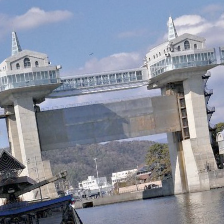

In [180]:
img = data.train_ds[120][0]
img

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


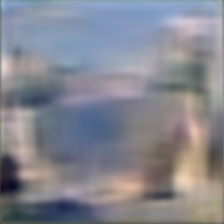

In [181]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

learn.model.eval()
learn2.model.eval()
learn3.model.eval()
learn4.model.eval()
learn5.model.eval()
with torch.no_grad():
  pred = learn.model.encode(example.unsqueeze_(0).cuda())
  pred = learn2.model.encode(pred)
  pred = learn3.model.encode(pred)
  pred = learn4.model.encode(pred)
  pred = learn5.model(pred)
  pred = learn4.model.decode(pred)
  pred = learn3.model.decode(pred)
  pred = learn2.model.decode(pred)
  pred = learn.model.decode(pred)

Image(pred.squeeze(0).cpu())

Theimage is very blurry now, however the two sides to the flood gate still stand out, again suggestioning a good representation in the lower levels, the recreation may just be inaccurate, this makes sense due to the first layers being a pretrained resnet which are built for object identification.

In [179]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

learn.model.eval()
learn2.model.eval()
learn3.model.eval()
learn4.model.eval()
learn5.model.eval()
with torch.no_grad():
  print(example.shape)
  pred = learn.model.encode(example.unsqueeze_(0).cuda())
  print(pred.shape)
  pred = learn2.model.encode(pred)
  print(pred.shape)
  pred = learn3.model.encode(pred)
  print(pred.shape)
  pred = learn4.model.encode(pred)
  print(pred.shape)
  pred = learn5.model.encode(pred)
  print(pred.shape)
  pred = learn5.model.decode(pred)
  pred = learn4.model.decode(pred)
  pred = learn3.model.decode(pred)
  pred = learn2.model.decode(pred)
  pred = learn.model.decode(pred)

torch.Size([3, 224, 224])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 56, 56])
torch.Size([1, 128, 28, 28])
torch.Size([1, 256, 14, 14])
torch.Size([1, 512, 7, 7])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
learn5.save('ae_res_5')

# Autoencoder 6

## Data

In [182]:
learn5.model.eval()
encoded_train_batches = torch.tensor(encoded_train_batches).cuda()
encoded_valid_batches = torch.tensor(encoded_train_batches).cuda()

with torch.no_grad():

    encoded_train_batches = learn5.model.encode(encoded_train_batches);  
    encoded_valid_batches = learn5.model.encode(encoded_valid_batches);

encoded_train_batches = encoded_train_batches.cpu().numpy()
encoded_valid_batches = encoded_valid_batches.cpu().numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
train_ds, valid_ds = ArrayDataset(encoded_train_batches, encoded_train_batches), ArrayDataset(encoded_valid_batches, encoded_valid_batches)

In [0]:
data6 = DataBunch.create(train_ds, valid_ds, bs=32)

## Model

In [198]:
resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
resnet = nn.Sequential(*(list(resnet.children())))
resnet[8]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


AdaptiveAvgPool2d(output_size=(1, 1))

In [0]:
class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)


In [0]:
class AutoEncoder6(nn.Module):
    def __init__(self):
        super(AutoEncoder6, self).__init__()

        

        self.encoder = nn.Sequential(AdaptiveConcatPool2d())

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor = 3.5, mode = 'bilinear'),
            nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

In [0]:
autoencoder6 = AutoEncoder6()
learn6 = Learner(data6, autoencoder6, loss_func = F.mse_loss)

In [202]:
learn6.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,13.699718,12.537899,00:01


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


## Training

In [203]:
learn6.lr_find()

epoch,train_loss,valid_loss,time
0,13.518467,#na#,00:01
1,13.516191,#na#,00:00
2,13.517337,#na#,00:00
3,13.507897,#na#,00:00
4,13.478144,#na#,00:00
5,13.311515,#na#,00:00
6,12.341291,#na#,00:00
7,12.656243,#na#,00:00


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-01
Min loss divided by 10: 1.32E-01


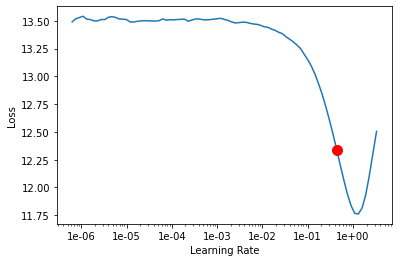

In [204]:
learn6.recorder.plot(suggestion = True)

In [205]:
learn6.fit_one_cycle(100, max_lr = 4.37e-01)

epoch,train_loss,valid_loss,time
0,12.903945,11.694655,00:01
1,12.264203,10.534556,00:01
2,11.625175,9.759672,00:01
3,10.926943,8.551374,00:01
4,10.098458,7.250488,00:01
5,9.190934,6.271816,00:01
6,8.310422,5.817205,00:01
7,7.532515,5.530120,00:01
8,6.896311,5.175354,00:01
9,6.384957,5.050409,00:01


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


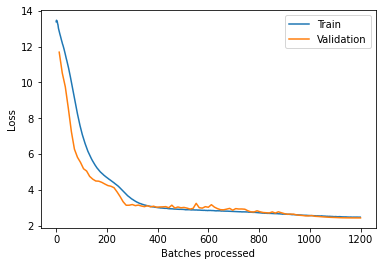

In [207]:
learn6.recorder.plot_losses()

In [208]:
learn6.lr_find()

epoch,train_loss,valid_loss,time
0,2.464087,#na#,00:00
1,2.461410,#na#,00:00
2,2.460727,#na#,00:00
3,2.459387,#na#,00:00
4,2.457427,#na#,00:00
5,2.460051,#na#,00:00
6,2.490344,#na#,00:00
7,2.676242,#na#,00:00


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.58E-07


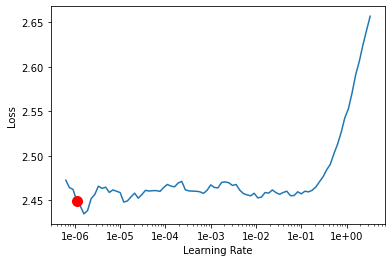

In [209]:
learn6.recorder.plot(suggestion=True)

In [210]:
learn6.fit_one_cycle(100, max_lr = 1.10e-06)

epoch,train_loss,valid_loss,time
0,2.465463,2.427700,00:01
1,2.464437,2.427905,00:01
2,2.458890,2.427800,00:01
3,2.460842,2.427747,00:01
4,2.461280,2.427789,00:01
5,2.459177,2.427770,00:01
6,2.459646,2.427728,00:01
7,2.460163,2.427745,00:01
8,2.460103,2.427703,00:01
9,2.460778,2.427934,00:01


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
learn6.save('ae_res_6')

## Results

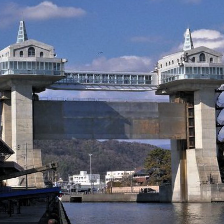

In [212]:
img = data.train_ds[120][0]
img

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


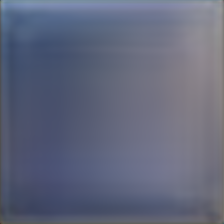

In [213]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

learn.model.eval()
learn2.model.eval()
learn3.model.eval()
learn4.model.eval()
learn5.model.eval()
learn6.model.eval()
with torch.no_grad():
  pred = learn.model.encode(example.unsqueeze_(0).cuda())
  pred = learn2.model.encode(pred)
  pred = learn3.model.encode(pred)
  pred = learn4.model.encode(pred)
  pred = learn5.model.encode(pred)
  pred = learn6.model(pred)
  pred = learn5.model.decode(pred)
  pred = learn4.model.decode(pred)
  pred = learn3.model.decode(pred)
  pred = learn2.model.decode(pred)
  pred = learn.model.decode(pred)
Image(pred.squeeze(0).cpu())

In [0]:
def plot_progression(img):
  img1, pred1 = learn.model(img), learn.model.encode(img)
  img2, pred2 = learn.model.decode(learn2.model(pred1)), learn2.model.encode(pred1)
  img3, pred3 = learn.model.decode(learn2.model.decode(learn3.model(pred2))), learn3.model.encode(pred2)
  img4, pred4 = learn.model.decode(learn2.model.decode(learn3.model.decode(learn4.model(pred3)))), learn4.model.encode(pred3)
  img5, pred5 = learn.model.decode(learn2.model.decode(learn3.model.decode(learn4.model.decode(learn5.model(pred4))))), learn5.model.encode(pred4)
  img6 = learn.model.decode(learn2.model.decode(learn3.model.decode(learn4.model.decode(learn5.model.decode(learn6.model(pred5))))))

  return img1.squeeze(0).cpu(), img2.squeeze(0).cpu(), img3.squeeze(0).cpu(), img4.squeeze(0).cpu(), img5.squeeze(0).cpu(), img6.squeeze(0).cpu()

In [221]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]
example = example.unsqueeze_(0).cuda()

imgs = plot_progression(example)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


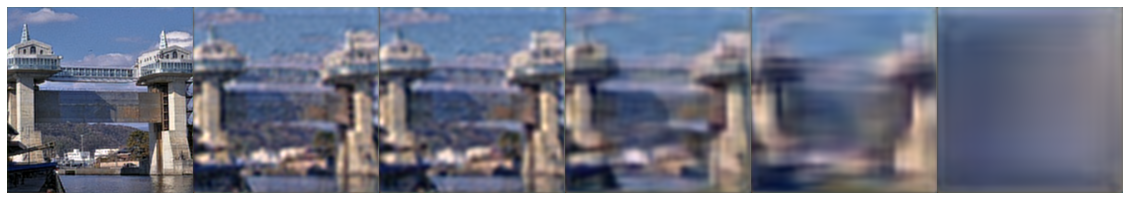

In [226]:
imgs = [img.detach() for img in imgs]
Image(torch.cat(imgs, axis = -1)).show(figsize = (20, 10))